In [91]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [120]:
os.listdir(os.path.join(main_folder,"gen01_red-blue"))[0] # this grabs first file from directory listed

'1.png'

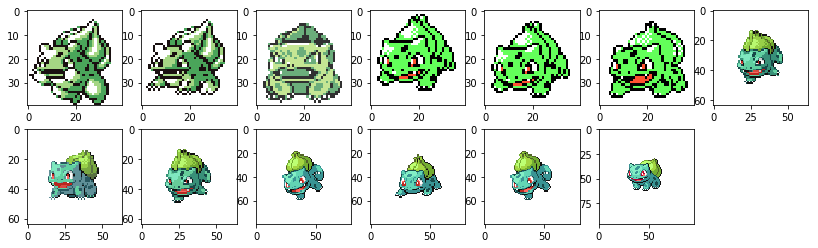

In [140]:
main_folder = "sprites/pokemon/main-sprites/main-sprites/"
i = 0
plt.figure(figsize=(14,4))
for folders in os.listdir(main_folder):  
    first_img = os.listdir(os.path.join(main_folder, folders))[0]
    img = mpimg.imread(os.path.join(main_folder, folders, first_img))
    plt.subplot(2,7,i+1)
    plt.imshow(img)
    i += 1

plt.show()

# Data Preparation

In [136]:
from skimage import color, filters, measure, morphology, transform

from scipy import ndimage

from math import ceil, floor

from functools import reduce

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os

def bbox_reducer(a,b):
    """Reduces two bounding boxes tuples to a bounding box
    encompassing both. The bounding box format expected is
    
    (min_row, min_col, max_row, max_col)
    
    Used with the reduce function to merge bounding boxes
    
    """
    min_row = min(a[0],b[0])
    min_col = min(a[1],b[1])
    max_row = max(a[2],b[2])
    max_col = max(a[3],b[3])
    return (min_row, min_col, max_row, max_col)

def plot_intermediate_steps(arr):
    """
    Plot a sequence of intermediate steps
    """
    n_img = len(arr)
    plt.figure(figsize=(16,24))
    
    for idx, item in enumerate(arr):
        image, cmap, box = item
        ax = plt.subplot(1,n_img,idx+1)
        plt.imshow(image,cmap)
        if box:
            ax.add_patch(box)
    plt.show()
    
def center_and_resize(image,new_size = (64,64),plot=False,square=True, id = None):
    #Criando as máscaras que representam os objetos
    image_bw = color.rgb2gray(image)
    image_countour = filters.sobel(image_bw)
    image_filled = ndimage.binary_fill_holes(image_countour)
    
    image_mask = morphology.convex_hull_image(image_filled)
    
    #Identificando os objetos na imagem
    labels, n_objects = ndimage.label(image_mask)
    regions = measure.regionprops(labels)
    slices = ndimage.find_objects(labels)

    #Getting Bounding box that encompasses all regions
    bbox_list = [r.bbox for r in regions]
    min_row, min_col, max_row, max_col = reduce(bbox_reducer,bbox_list)
    
    #If the bounding box is not squared, make it so
    if square:
        len_row = max_row - min_row
        len_col = max_col - min_col

        if len_row > len_col:
            min_col -= ceil((len_row - len_col)/2)
            max_col += floor((len_row - len_col)/2)
        else:
            min_row -= ceil((len_col - len_row)/2)
            max_row += floor((len_col - len_row)/2)      
    

    #We may have some out of bound stuff hapenning here
    if (max_row - min_row) > image.shape[0]:
        raise ValueError("ID = {id} - Bounding box height is greater than image height".format(id=id))
    if (max_col - min_col) > image.shape[1]:
        raise ValueError("ID = {id} - Bounding box width is greater than image width".format(id=id))
        
    #If Bounding box exceeds image limits, we shift it inside
    if min_row < 0:
        max_row += abs(min_row)
        min_row = 0
    if min_col < 0:
        max_col += abs(min_col)
        min_col = 0
    if max_row >= image.shape[1]:
        min_row -= max_row - image.shape[1] + 1
        max_row = image.shape[0]-1
    if max_col >= image.shape[1]:
        min_col -= max_col - image.shape[1] + 1
        max_col = image.shape[1]-1    
    
    image_slice = (
        slice(min_row,max_row,None) ,
        slice(min_col,max_col,None)               
    )
    
    image_bounded = image[image_slice]
    
    image_resize = transform.resize(image_bounded,new_size)
    
    if plot:
        image_box = patches.Rectangle(
            (min_col,min_row),
            max_row - min_row,  
            max_col - min_col,  
            fc = "none",
            ec = "red"
        )
        img_arr = [
            (image,None,None),
            (image_bw,"gray",None),
            (image_countour,"gray",None),
            (image_filled,"gray",None),
            (image_mask,"gray",None),
            (image,None,image_box),
            (image_resize,None,None)
        ]
        plot_intermediate_steps(img_arr)
    
    return image_resize    

In [176]:
from math import ceil
from IPython.display import display

image_list = []

for path, subdirs, files in os.walk(main_folder):
    for filename in files:
        f = os.path.join(path, filename)
        image = mpimg.imread(f)
        image_resize = center_and_resize(image,plot=False,id=f)
        image_list.append((image,image_resize))

# n_cols = 6
# n_rows = ceil(2*len(image_list)/n_cols)
# plt.figure(figsize=(16,256))
# for idx, image_pair in enumerate(image_list):
#     image, image_resize = image_pair
#     plt.subplot(100,6,2*idx+1)
#     plt.imshow(image)
#     plt.subplot(100,6,2*idx+2)
#     plt.imshow(image_resize)        

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [171]:
import warnings
import os
import matplotlib.image as img
from skimage import io


main_folder = "./sprites/pokemon/main-sprites/"
dest_folder = "./sprites/pokemon/centered-sprites/"

if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)

gen_folders = {    
    "gen01_red-blue" : 151,
    "gen01_red-green" : 151,
    "gen01_yellow" : 151,
    "gen02_crystal" : 251,
    "gen02_gold" : 251,
    "gen02_silver" : 251,
    "gen03_emerald" : 386,
    "gen03_firered-leafgreen" : 151,
    "gen03_ruby-sapphire" : 386,
    "gen04_diamond-pearl" : 493,
    "gen04_heartgold-soulsilver" : 386,
    "gen04_platinum" : 386,
    "gen05_black-white" : 649
}

for gen, max_pkm in gen_folders.items():
    print("Starting",gen)
    main_gen_folder = os.path.join(main_folder,gen)
    dest_gen_folder = os.path.join(dest_folder,gen)
    if not os.path.exists(dest_gen_folder):
        os.makedirs(dest_gen_folder)
    for pkm_id in range(1,max_pkm+1):
        image_file = "{id}.png".format(id=pkm_id)
        image_path = os.path.join(main_gen_folder,image_file)        
        try:
            image = mpimg.imread(image_path)
            new_image = center_and_resize(image,plot=False,id=image_path)
            new_image_path = os.path.join(dest_gen_folder,image_file)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                io.imsave(new_image_path,new_image)
        except FileNotFoundError:
            print(" - {file} not found".format(file=image_path))
print("Finished")
    

('Starting', 'gen03_firered-leafgreen')


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:100: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


('Starting', 'gen01_red-green')
('Starting', 'gen03_emerald')
('Starting', 'gen05_black-white')


NameError: name 'FileNotFoundError' is not defined